In [1]:
from Vaults_lib import *
import numpy as np
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import re

%matplotlib widget

In [2]:
Data = pd.read_csv('./vaultstvl5.csv')

In [3]:
labels = []
price_labels = []

for name in Data.columns:
    if ('price' in name.lower()): #we need only prices
        label = re.sub(r' Price', '', name)
        labels.append(label)
        price_labels.append(name)

Prices = pd.DataFrame()
Prices['Block'] = Data['Block']
Prices = Prices.merge(Data.loc[:, ['Block', 'Date'] + price_labels], how='outer')
Prices['Date'] = pd.to_datetime(Prices['Date'])
Prices = Prices.loc[Prices['Date'] > pd.to_datetime("09-05-2021"), :]
Prices.head()

,Block,Date,MIM Price,FRAX Price,USDN Price,alUSD Price,mUSD Price
15,13165654,2021-09-05 12:14:51,1.0019,1.0410,1.0773,1.0416,1.0395
16,13172115,2021-09-06 12:15:53,1.0019,1.0410,1.0778,1.0416,1.0395
17,13178576,2021-09-07 12:20:49,1.0020,1.0410,1.0783,1.0423,1.0395
18,13185037,2021-09-08 12:15:23,1.0020,1.0421,1.0794,1.0423,1.0395
19,13191498,2021-09-09 12:24:43,1.0020,1.0421,1.0799,1.0431,1.0395


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
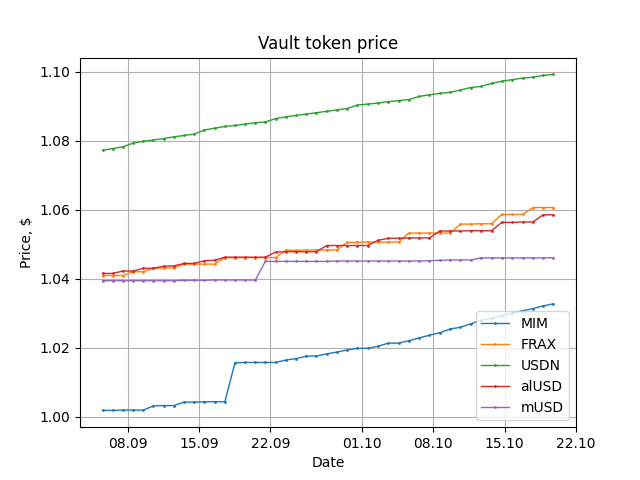

In [24]:
%matplotlib widget

for col in Prices.columns:
    if ('price' in col.lower()):
        plt.plot(Prices['Date'], Prices[col], lw=1, marker='.', markersize=2)

plt.grid()
plt.title('Vault token price')
plt.xlabel('Date')
plt.ylabel('Price, $')
plt.legend(labels)

myFmt = mdates.DateFormatter('%d.%m')
plt.gca().xaxis.set_major_formatter(myFmt)


In [5]:
def calc_price_velocity(prices, step, dates=None):

    if not(isinstance(step, int) or (step <= 0)):
        print('What the fuck?')
        return

    lp = len(prices)

    if (dates):

        ld = len(dates)
        
        if (lp != ld):
            print('What the fuck?')
            return

    l = lp

    velocities = np.zeros(l)

    for i in range(step, l):
        D = (prices[i] - prices[i-step])/step
        velocities[i] = D
    
    return velocities

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
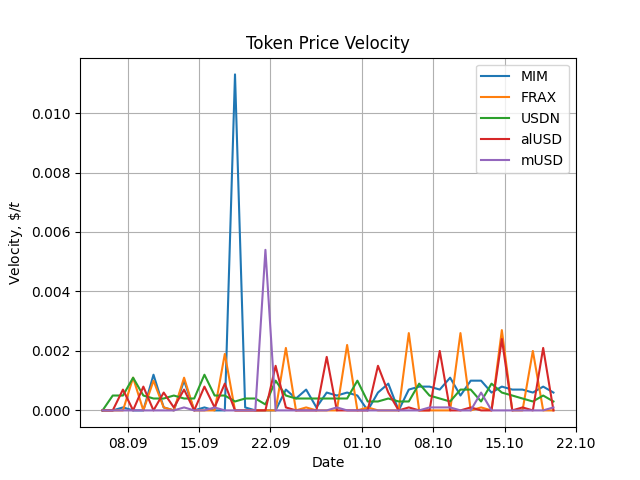

In [6]:

%matplotlib widget

Velocities = deepcopy(Prices.iloc[:, 0:2])

vel_labels = []

for label in labels:
    vel_labels.append(label + ' Price Velocity')

Velocities = Velocities.reindex(columns = list(Velocities.columns) + list(vel_labels), fill_value=0)

for i in range(2, len(Velocities.columns)):

    Velocities.iloc[:, i] = calc_price_velocity(Prices.iloc[:, i].to_numpy(), 1)

for label in vel_labels:
    plt.plot(Velocities['Date'], Velocities[label])

plt.legend(labels)
plt.grid()
plt.title('Token Price Velocity')
plt.xlabel('Date')
plt.ylabel('Velocity, $\\$/t$')

myFmt = mdates.DateFormatter('%d.%m')
plt.gca().xaxis.set_major_formatter(myFmt)


In [7]:
def calc_shares_price_velocity(velocities_):

    if (isinstance(velocities_, np.ndarray)):
        velocities = velocities_
    elif (isinstance(velocities_, list)):
        velocities = np.array(velocities_)
    total_velocity = sum(velocities)
    shares = velocities/total_velocity

    return shares


In [8]:
Velocities.head(5)

,Block,Date,MIM Price Velocity,FRAX Price Velocity,USDN Price Velocity,alUSD Price Velocity,mUSD Price Velocity
15,13165654,2021-09-05 12:14:51,0.0000,0.0000,0.0000,0.0000,0.0
16,13172115,2021-09-06 12:15:53,0.0000,0.0000,0.0005,0.0000,0.0
17,13178576,2021-09-07 12:20:49,0.0001,0.0000,0.0005,0.0007,0.0
18,13185037,2021-09-08 12:15:23,0.0000,0.0011,0.0011,0.0000,0.0
19,13191498,2021-09-09 12:24:43,0.0000,0.0000,0.0005,0.0008,0.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
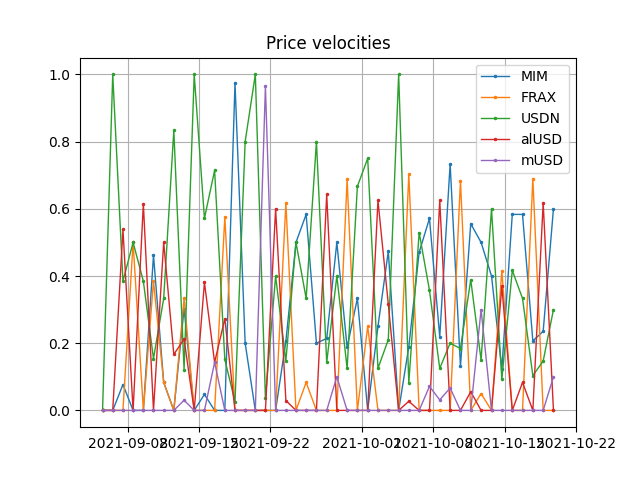

In [9]:
%matplotlib widget

PoolShares = pd.DataFrame(deepcopy(Velocities['Date']))

ps_labels = [label + ' Share' for label in labels]

PoolShares = PoolShares.reindex(columns = list(PoolShares.columns) + list(ps_labels), fill_value=0)

for idx, day in enumerate(PoolShares['Date']):

    if (idx >= 1):
        vels = Velocities.iloc[idx, 2:].to_numpy()
        PoolShares.iloc[idx, 1:] = calc_shares_price_velocity(vels)

PoolShares.head()

for c in PoolShares.iloc[:, 1:].columns:
    plt.plot(PoolShares['Date'], PoolShares[c], lw=1, marker='.', markersize=3)

plt.title('Price velocities')
plt.grid()
plt.legend(labels)

In [10]:
funds = np.zeros(len(labels))

for i in range(len(labels)):
    funds[i] = 300000

money = np.zeros((len(Prices), len(labels)), dtype=float)

## 1. HODL

This strategy is just HODLing vault tokens and relying on their growth due to comission accumulation

In [11]:
#1. HODL
print('1. HODL Strategy:')
init_TVL = sum(funds*Prices[price_labels].iloc[1, :])
final_TVL = sum(funds*Prices[price_labels].iloc[-1, :])
gain = final_TVL - init_TVL
gain_yearly = gain/len(Prices)*365
APR = gain_yearly/init_TVL*100

print('Initial TVL: ${:0,.3f}'.format(init_TVL))
print('Final TVL: {:0,.3f}'.format(final_TVL))
print('Gain: ${:0,.3f} over {:0,.3f} days === {:0,.3f}% APR'.format(gain, len(Prices), APR))


1. HODL Strategy:
Initial TVL: $1,560,540.000
Final TVL: 1,589,280.000
Gain: $28,740.000 over 45.000 days === 14.938% APR


## 2. Price Velocity Drop
After each jump in token price, we rebalance the asset basket to minimize the share of the token that recently jumped in price.

Suppose we have $n$ different tokens with price at the $i^{th}$ timestep  $P_{i}^{(k)}$

For each step we calculate the price jump relative to other tokens like this:

$$
\delta P_{i}^{(k)} = \frac{P_{i}^{(k)} - P_{i-1}^{(k)}}{P_{i-1}^{(k)}}\\


\delta P_{i_{relative}}^{(k)} = \frac{\delta P_{i}^{(k)}}{\sum\limits_{j=1}^{n} \delta P_{i}^{(j)}}
$$

Assuming that we sell $100\%$ of the token that increased in the price most, we sell another tokens respectively to their relative price jump. Other tokens are replenished in equal amounts. If we denote the amount of token $k$ in the basket as $T^{(k)}$, that can be written as:

$$
\delta T_{i}^{(k)} = -\frac{\delta P_{i_{relative}}^{(k)}}{\max\limits_{j} \big \{ \delta P_{i_{relative}}^{(j)} \big \}} T_{i}^{(k)}
$$

In [21]:
%matplotlib widget

n = len(labels) #number of Vaults
d = len(Prices) #number of days

funds = np.zeros((d, n), dtype=np.float64)
for i in range(len(labels)):
    funds[0][i] = 300000

money = np.zeros((d, n), dtype=np.float64)
prices = Prices[price_labels].to_numpy()
dates = Prices.loc[:, 'Date'].to_numpy()

delta = 1 #number of steps to average price velocity

for i in range(1, d):
    
    funds[i] = funds[i-1]

    jumps = np.zeros(n, dtype=np.float64)
    for j in range(n):
        jumps[j] = ((prices[i][j] - prices[i-1][j])/delta)/prices[i-1][j] #relative jump in price

    #shifting and stretching so that jumps are from -1 to 1
    jumps = jumps - np.mean((max(jumps), min(jumps)))
    jumps = jumps / max(abs(jumps))

    relative_jumps = jumps

    '''relative_jumps = np.zeros(n, dtype=np.float64)
    for j in range(n):
        relative_jumps[j] = jumps[j]/total_jump
        
    relative_jumps = relative_jumps/max(relative_jumps) #this should give us relative amounts to sell
    print("relative jumps: ", relative_jumps)
    print('\n')
    '''

    cash = 0
    counter = 0 #we count the number of tokens we sold

    for k in range(n):
        if (relative_jumps[k] > 0):
            token_sold = relative_jumps[k]*funds[i][k]
            cash += token_sold * prices[i][k]
            funds[i][k] -= token_sold
            counter += 1

    sum_negative_jumps = 0
    for k in range(n):
        if (relative_jumps[k] <= 0):
            sum_negative_jumps += relative_jumps[k]

    for k in range(n):
        if (relative_jumps[k] <= 0):
            token_bought = cash * relative_jumps[k]/sum_negative_jumps/prices[i][k]
            funds[i][k] += token_bought

In [22]:
init_TVL2 = sum(funds[0] * prices[0])
final_TVL2 = sum(funds[-1] * prices[-1])
gain2 = final_TVL2 - init_TVL2
gain_yearly2 = gain2/d*365
APR2 = gain_yearly2/init_TVL2*100

print('Initial TVL: ${:0,.3f}'.format(init_TVL2))
print('Final TVL: ${:0,.3f}'.format(final_TVL2))
print('Gain: ${:0,.3f} over {:d} days === {:0,.3f}% APR'.format(gain2, d, APR2))

Initial TVL: $1,560,390.000
Final TVL: $1,581,626.398
Gain: $21,236.398 over 45 days === 11.039% APR


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
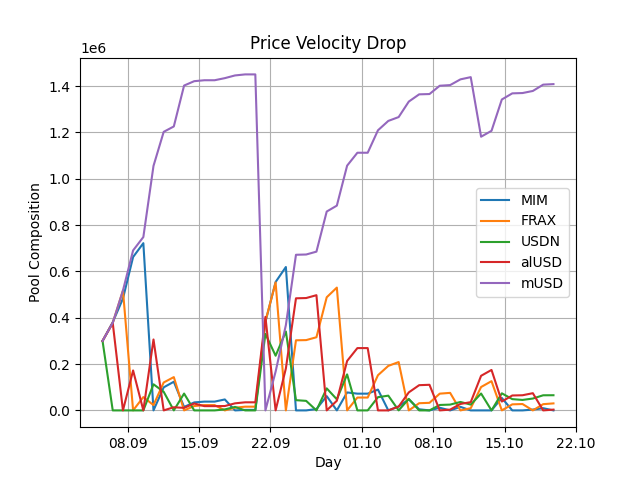

In [23]:
%matplotlib widget

for k in range(n):
    plt.plot(dates, funds[:, k])

plt.title('Price Velocity Drop')
plt.grid()
plt.xlabel('Day')
plt.ylabel('Pool Composition')
plt.legend(labels)

myFmt = mdates.DateFormatter('%d.%m')
plt.gca().xaxis.set_major_formatter(myFmt)

## 3. Slope Optimization

In this strategy we 

In [15]:
from scipy.stats import linregress as linreg
from scipy.fft import fft, ifft
plt.ion()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
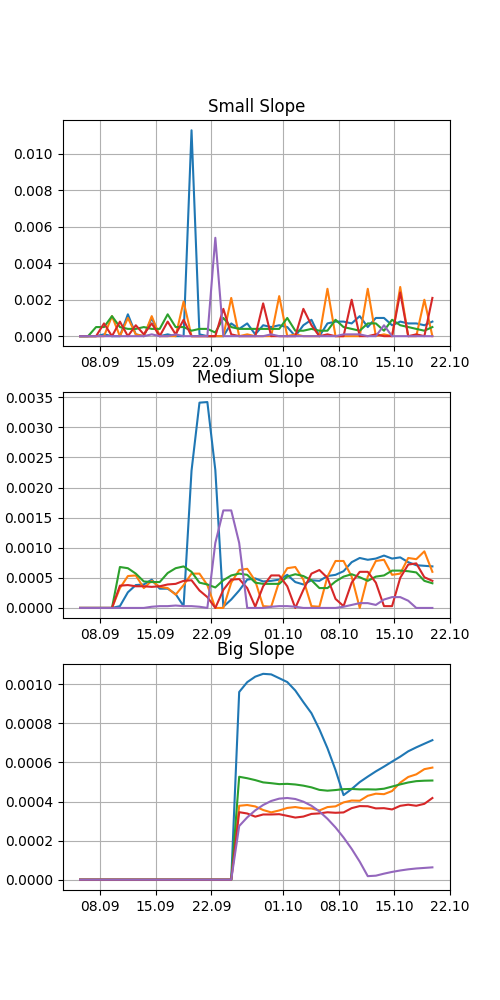

In [25]:
%matplotlib widget

n = len(labels)
days = Prices['Date'].to_numpy()
d = len(days)
days_i = np.arange(d)

prices
price_slope_small = np.zeros((d, n), dtype=np.float64)
price_slope_medium = np.zeros((d, n), dtype=np.float64)
price_slope_big = np.zeros((d, n), dtype=np.float64)

delta_small = 2
delta_medium = 5
delta_big = 20

for i in range(d):

    if (i >= delta_small):
        for k in range(n):
            price_slope_small[i][k] = linreg(days_i[i-delta_small:i], prices[i-delta_small:i, k])[0]

    if (i >= delta_medium):
        for k in range(n):
            price_slope_medium[i][k] = linreg(days_i[i-delta_medium:i], prices[i-delta_medium:i, k])[0]
    '''elif (i >= 2):            
        for k in range(n):
            price_slope_medium[i][k] = linreg(days_i[i-i:i], prices[i-i:i, k])[0]'''


    if (i >= delta_big):
        for k in range(n):
            price_slope_big[i][k] = linreg(days_i[i-delta_big:i], prices[i-delta_big:i, k])[0]
    '''elif (i >= 2):
        for k in range(n):
            price_slope_big[i][k] = linreg(days_i[i-i:i], prices[i-i:i, k])[0]'''


fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

for i in range(n):
    ax1.plot(days, price_slope_small[:, i])
    ax2.plot(days, price_slope_medium[:, i])
    ax3.plot(days, price_slope_big[:, i])

ax1.set_title('Small Slope')
ax2.set_title('Medium Slope')
ax3.set_title('Big Slope')

fig.set_size_inches(5, 10)

myFmt = mdates.DateFormatter('%d.%m')
ax1.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_major_formatter(myFmt)
ax3.xaxis.set_major_formatter(myFmt)

ax1.grid()
ax2.grid()
ax3.grid()


C:\Program Files\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Program Files\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Program Files\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Program Files\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Program Files\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Program Files\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1333: C

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
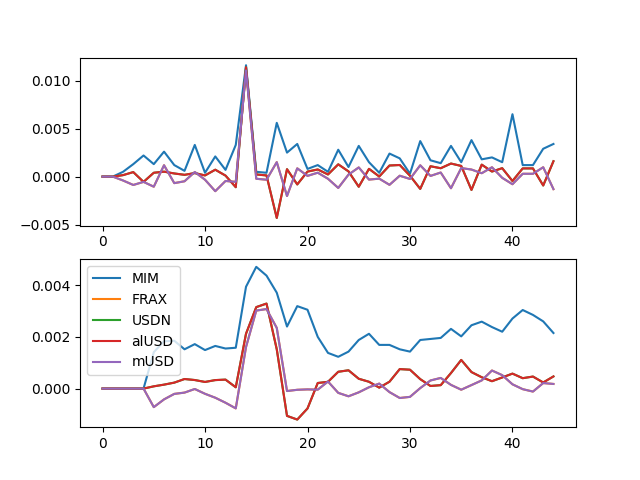

In [26]:
%matplotlib widget

small_fft = fft(price_slope_small)
medium_fft = fft(price_slope_medium)

fig, (ax1, ax2) = plt.subplots(2, 1)
for i in range(n):
    ax1.plot(small_fft[:, i])
    ax2.plot(medium_fft[:, i])



plt.legend(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
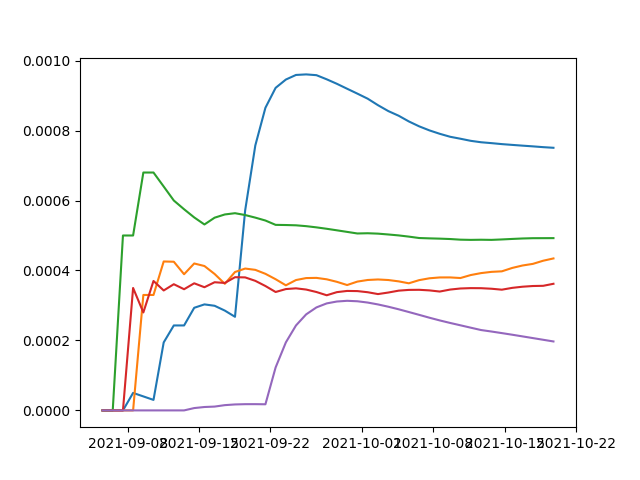

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
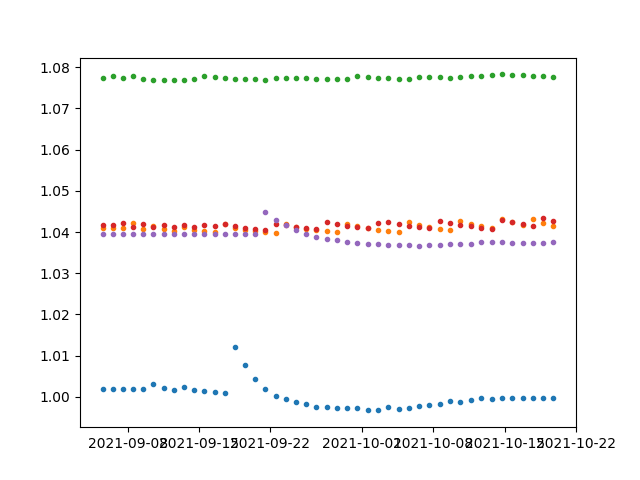

In [18]:
%matplotlib widget

d = len(days)
n = len(labels)

days_i = np.arange(d)


big_sloppa = np.zeros((d, n), dtype=np.float64)
delta_thicc = 30

for i in range(d):
    if (i >= 2):
        for k in range(n):
            big_sloppa[i, k] = linreg(days_i[i - i:i], prices[i-i:i, k])[0]


for k in range(n):
    plt.plot(days, big_sloppa[:, k])

plt.figure()

voennoe_prestuplenie = np.zeros((d, n))
for k in range(n):
    voennoe_prestuplenie[:, k] = prices[:, k] - big_sloppa[:, k] * days_i
    plt.plot(days, voennoe_prestuplenie[:, k], lw=0, marker='.')

C:\Program Files\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Program Files\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Program Files\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Program Files\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Program Files\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
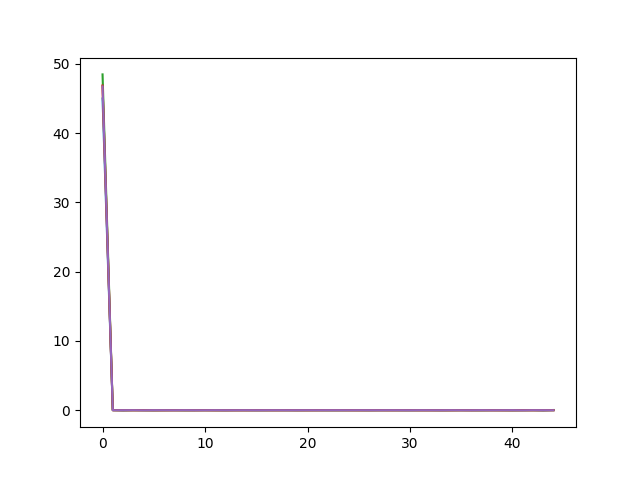

In [27]:
%matplotlib widget

for k in range(n):
    plt.plot(days_i, fft(voennoe_prestuplenie[:, k]))

C:\Program Files\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
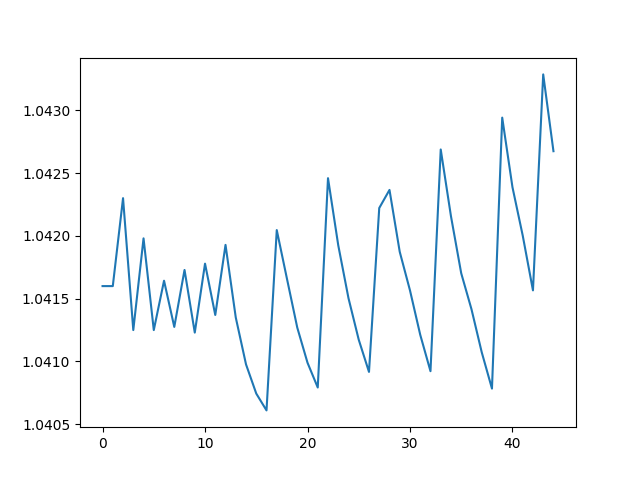

In [28]:
%matplotlib widget
plt.plot(ifft(fft(voennoe_prestuplenie[:, 3])))